In [72]:
!qbraid jobs enable default

Successfully enabled qBraid Quantum Jobs in the default environment.
Every AWS job you run will now be submitted through the qBraid API, so no access keys/tokens are necessary. 

To disable, run: `qbraid jobs disable default`


In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from qbraid import device_wrapper, job_wrapper, get_jobs
from collections import Counter

In [20]:
#Reminder: cirq.CNOT(control,target)
#Reference:
#https://quantumcomputing.stackexchange.com/questions/9623/constructing-a-circuit-for-c1u-for-rotation-operators-with-two-single-qubit

def cRy(theta,target,control):
    yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=-theta/2).on(target)
    yield cirq.CNOT(control,target)
    yield cirq.Ry(rads=theta/2).on(target)

def xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[0])
    yield cirq.CNOT(sys[1],env[0])
    yield from cRy(2*np.arcsin(np.sqrt(p)),sys[1],env[0])
    # yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[1]).controlled_by(env[0])
    yield cirq.CNOT(sys[1],env[0])

def zz_xx_pump(sys,env,p):
    yield cirq.CNOT(sys[1],sys[0])
    yield cirq.X(env[0])
    yield cirq.CNOT(sys[0],env[0])
    yield from cRx(2*np.arcsin(np.sqrt(p)),sys[0],env[0])
    # yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[0]).controlled_by(env[0])
    yield cirq.CNOT(sys[0],env[0])
    yield cirq.H(sys[1])
    yield cirq.X(env[1])
    yield cirq.CNOT(sys[1],env[1])
    yield from cRx(2*np.arcsin(np.sqrt(p)),sys[1],env[1])
    # yield cirq.Rx(rads=np.arccos(1-2*p)).on(sys[1]).controlled_by(env[1])
    yield cirq.CNOT(sys[1],env[1])

In [3]:
env = [cirq.LineQubit(0),cirq.LineQubit(3)]
sys = [cirq.LineQubit(1),cirq.LineQubit(2)]
probs = np.linspace(0,1,num=5)
repcnt = 1024

Mappings:

$\vert \phi+ \rangle = \vert 00 \rangle$

$\vert \psi+ \rangle = \vert 01 \rangle$

$\vert \phi- \rangle = \vert 10 \rangle$

$\vert \psi- \rangle = \vert 11 \rangle$

In [4]:
def calc_pump_sim(pump,sys,env,p,repcnt):
    
    simulator = cirq.Simulator()
    final_hist = Counter()
    
    for j in range(2**2):
        circuit = cirq.Circuit()
        if (j&1) == 1:
            circuit.append(cirq.X.on(sys[0]))
        if (j&1) == 2:
            circuit.append(cirq.X.on(sys[1]))
        circuit.append(pump(sys,env,p))
        circuit.append(cirq.measure(sys, key = 'answer'))
        
        result = simulator.run(circuit,repetitions=repcnt)
        histogram = result.histogram(key = 'answer')
        final_hist += histogram

    for x in final_hist:
        final_hist[x]/=(4*repcnt)

    return final_hist

In [61]:
device_id = "aws_oqc_lucy"
device = device_wrapper(device_id)
print(device.metadata())

{'id': 'arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy', 'name': 'Lucy', 'provider': 'Oxford', 'vendor': 'AWS', 'numQubits': 8, 'deviceType': 'QPU', 'status': 'ONLINE', 'queueDepth': 0}


In [77]:
ctest = cirq.Circuit(xx_pump(sys,env,0.2))
ctest.append(cirq.X.on(sys[0]))
ctest_transpiled = device.transpile(ctest)
ctest_transpiled.probability(target=[1,2])
print(ctest_transpiled)
print(device.verify_run(ctest_transpiled))

T  : |0|1|2|   3    |4|Result Types|
                                    
q0 : -X---X-C--------X--------------
          | |        |              
q1 : -X-X-|-|--------|-Probability--
      |   | |        | |            
q2 : -C-H-C-Rx(0.93)-C-Probability--

T  : |0|1|2|   3    |4|Result Types|
None


/opt/.qbraid/environments/qbraid_000000/pyenv/lib/python3.11/site-packages/qbraid/providers/device.py:158: UserWarning: Device is currently offline. Depending on the provider queueing system, submitting this job may result in an exception or a long wait time.
  warnings.warn(


In [74]:
def oqc_create_jobs(pump,sys,env,p,repcnt):
    job_id_list = []
    for j in range(2**2):
        circuit = cirq.Circuit()
        if (j&1) == 1:
            circuit.append(cirq.X.on(sys[0]))
        if (j&1) == 2:
            circuit.append(cirq.X.on(sys[1]))
        circuit.append(pump(sys,env,p))
        transpiled_circuit = device.transpile(circuit)
        job = device.run(transpiled_circuit,shots=repcnt)
        job_id_list.append(job.id)
    return job_id_list

<h2>ZZ XX pump:</h2>

In [75]:
zz_xx_job_ids = []

In [ ]:
print('Job ids for probabilities',*probs)
for p in probs:
    job_ids = oqc_create_jobs(zz_xx_pump,sys,env,p,repcnt)
    zz_xx_job_ids.append(job_ids)

In [ ]:
print(zz_xx_job_ids)

<h2>Simulation:</h2>

In [18]:
hists = [calc_pump_sim(zz_xx_pump,sys,env,p,repcnt) for p in probs]

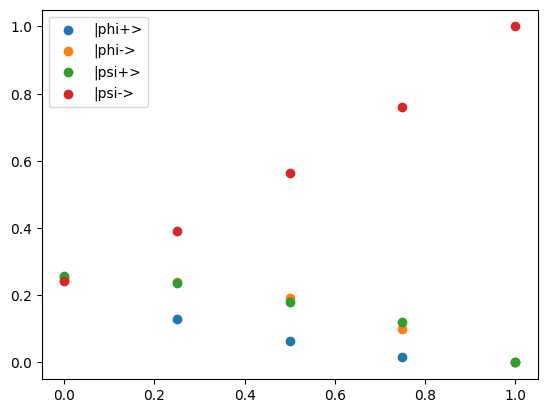

In [19]:
def calc_plot(hists):
    pops = [[],[],[],[]]
    for counts in hists:
        for i in range(4):
            pops[i].append(counts[i])

    plt.scatter(probs,pops[0],label='|phi+>')
    plt.scatter(probs,pops[1],label='|phi->')
    plt.scatter(probs,pops[2],label='|psi+>')
    plt.scatter(probs,pops[3],label='|psi->')
    plt.legend()
    plt.show()

calc_plot(hists)